# **Gun violence and its impact in US**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=c860a460d7cfaef9c1ff19de54345553e7abfe8ec8a5521f87951131b32c0fb4
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


**Create spark session**

In [ ]:
from pyspark.sql import SparkSession
session= SparkSession.builder.appName("newStream").getOrCreate()

##Data Description##

**Data source**- Kaggle

**Data link-** https://www.kaggle.com/code/erikbruin/gun-violence-in-the-us-eda-and-rshiny-app/report

**Data Size-** 29 Variables and 239,678 rows in our data.

**Description-** Understanding the patterns and characteristics of gun violence incidents in the United States is of paramount importance for policymakers, law enforcement agencies, researchers, and advocacy groups. By analyzing such data, stakeholders can identify trends, risk factors, and vulnerable populations, leading to the development of targeted interventions aimed at reducing the incidence of gun-related violence and promoting community safety and well-being.

# **Feature Engineering**

In [ ]:
from pyspark.sql.functions import year, quarter, month, dayofmonth, dayofweek
from pyspark.sql.functions import col, when

# Initialize SparkSession
gun = session.read.csv("gun-violence.csv", header=True, inferSchema=True)

In [ ]:
gun.show()

+-----------+------------+--------------------+--------------+--------------------+------------------+---------+--------------------+--------------------+---------------------------+----------------------+--------------------+--------------------+------------------------+--------+--------------------+---------+---------------+--------------------+--------------------+---------------------+--------------------+--------------------+------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|incident_id|        date|               state|city_or_county|             address|          n_killed|n_injured|        incident_url|          source_url|incident_url_fields_missing|congressional_district|          gun_stolen|            gun_type|incident_characteristics|latitude|location_description|longitude|n_guns_involved|               notes|     participant_age|participant_age_group|  participant_gender|    participant_name|

In [ ]:
from pyspark.sql.functions import col, udf, isnan
from pyspark.sql.types import BooleanType
import pyspark.sql.functions as F

# UDF to check if a string column's value is numeric (integer)
def is_numeric(value):
    try:
        int(value)  # Try converting to an integer
        return True
    except ValueError:  # Conversion failed, so it's not an integer
        return False


is_numeric_udf = udf(is_numeric, BooleanType())

gun = gun.withColumn("incident_id", col("incident_id").cast("string"))

gun = gun.filter(
    col("incident_id").isNotNull() &  # Not null
    ~isnan("incident_id") &  # Not NaN
    is_numeric_udf("incident_id")  # Is numeric
)

gun.show()

+-----------+----------+--------------------+--------------+--------------------+--------+---------+--------------------+--------------------+---------------------------+----------------------+--------------------+--------------------+------------------------+--------+--------------------+---------+---------------+--------------------+--------------------+---------------------+--------------------+--------------------+------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|incident_id|      date|               state|city_or_county|             address|n_killed|n_injured|        incident_url|          source_url|incident_url_fields_missing|congressional_district|          gun_stolen|            gun_type|incident_characteristics|latitude|location_description|longitude|n_guns_involved|               notes|     participant_age|participant_age_group|  participant_gender|    participant_name|participant_relationship

In [ ]:
# Reformatting the date column
gun = gun.withColumn("date", gun["date"].cast("date"))

# Extracting year, quarter, month, day, and weekday
gun = gun.withColumn("year", year("date"))
gun = gun.withColumn("quarter", quarter("date"))
gun = gun.withColumn("month", month("date"))
gun = gun.withColumn("day", dayofmonth("date"))
gun = gun.withColumn("weekday", dayofweek("date"))

# Converting state and city_or_county to factor variables
gun = gun.withColumn("state", col("state").cast("string"))
gun = gun.withColumn("city_or_county", col("city_or_county").cast("string"))

# Exploring number of incidents by year
incidents_by_year = gun.groupBy("year").count().orderBy("year")

# Exploring number of incidents by quarter
incidents_by_quarter = gun.filter(gun["year"] != 2013).groupBy("year", "quarter").count().orderBy("year", "quarter")

# Exploring number of incidents by month
incidents_by_month = gun.filter(gun["year"] != 2018).groupBy("month").count().orderBy("month")

# Exploring number of incidents by weekday
incidents_by_weekday = gun.groupBy("weekday").count().orderBy("weekday")

# Displaying results
incidents_by_year.show()
incidents_by_quarter.show()
incidents_by_month.show()
incidents_by_weekday.show()

+----+-----+
|year|count|
+----+-----+
|2013|  278|
|2014|51854|
|2015|53579|
|2016|58763|
|2017|61401|
|2018|13802|
+----+-----+

+----+-------+-----+
|year|quarter|count|
+----+-------+-----+
|2014|      1|11109|
|2014|      2|12651|
|2014|      3|15530|
|2014|      4|12564|
|2015|      1|11329|
|2015|      2|14082|
|2015|      3|14949|
|2015|      4|13219|
|2016|      1|13449|
|2016|      2|14104|
|2016|      3|15714|
|2016|      4|15496|
|2017|      1|14837|
|2017|      2|16401|
|2017|      3|15539|
|2017|      4|14624|
|2018|      1|13802|
+----+-------+-----+

+-----+-----+
|month|count|
+-----+-----+
|    1|18165|
|    2|14717|
|    3|17888|
|    4|18628|
|    5|19930|
|    6|18755|
|    7|21126|
|    8|21040|
|    9|19656|
|   10|19890|
|   11|17974|
|   12|18106|
+-----+-----+

+-------+-----+
|weekday|count|
+-------+-----+
|      1|37052|
|      2|33760|
|      3|33307|
|      4|34126|
|      5|32561|
|      6|32775|
|      7|36096|
+-------+-----+



In [ ]:
gun.fillna(0, subset=["congressional_district","latitude","state_house_district"])
gun = gun.withColumn("congressional_district", col("congressional_district").cast("integer"))
gun = gun.withColumn("latitude", col("latitude").cast("double"))
gun = gun.withColumn("n_killed", col("n_killed").cast("integer"))
gun = gun.withColumn("n_injured", col("n_injured").cast("integer"))

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F

In [ ]:
@udf(IntegerType())
def count_stolen(gun_stolen):
  if gun_stolen:
    stolen_count = sum("Stolen" in part for part in gun_stolen.split("||"))
  else:
    stolen_count = 0
  return stolen_count

@udf(IntegerType())
def count_not_stolen(gun_stolen):
  if gun_stolen:
    not_stolen_count = sum("Not_Stolen" in part for part in gun_stolen.split("||"))
  else:
      not_stolen_count= 0
  return not_stolen_count

@udf(IntegerType())
def count_unknown(gun_stolen):
  if gun_stolen:
    unknown_count = sum("Unknown" in part for part in gun_stolen.split("||"))
  else:
      unknown_count= 0
  return unknown_count

gun = gun.withColumn("num_of_guns_stolen", count_stolen("gun_stolen")) \
       .withColumn("num_of_guns_not_stolen", count_not_stolen("gun_stolen")).withColumn("num_of_guns_unknown", count_unknown("gun_stolen"))


In [ ]:
columns_to_drop = ['incident_url', 'source_url', 'incident_url_fields_missing', 'notes', 'sources', 'location_description', 'address','participant_name']
gun = gun.drop(*columns_to_drop)

In [ ]:

# List of categorical columns to impute with 'Unknown'
categorical_columns = ['gun_type', 'incident_characteristics', 'participant_age_group', 'participant_gender', 'participant_status',"state","city_or_county","participant_relationship"]

# Impute missing values in these columns with 'Unknown'
for column in categorical_columns:
    gun = gun.na.fill({column: "Unknown"})

# Show the result to verify imputation
gun.show()

+-----------+----------+--------------------+--------------+--------+---------+----------------------+--------------------+--------------------+------------------------+--------+---------+---------------+--------------------+---------------------+--------------------+------------------------+--------------------+--------------------+--------------------+---------------------+----+-------+-----+---+-------+------------------+----------------------+-------------------+
|incident_id|      date|               state|city_or_county|n_killed|n_injured|congressional_district|          gun_stolen|            gun_type|incident_characteristics|latitude|longitude|n_guns_involved|     participant_age|participant_age_group|  participant_gender|participant_relationship|  participant_status|    participant_type|state_house_district|state_senate_district|year|quarter|month|day|weekday|num_of_guns_stolen|num_of_guns_not_stolen|num_of_guns_unknown|
+-----------+----------+--------------------+-----------

In [ ]:
numeric_columns = ['n_guns_involved', 'latitude', 'longitude','n_killed', 'n_injured','congressional_district']

for column in numeric_columns:
    gun = gun.na.fill({column: 0})

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# UDF to count occurrences of each age group
def count_age_group(age_str, age_group):
    if age_str:
        return age_str.count(age_group)
    return 0

# Register UDFs for each age group
count_adult_udf = udf(lambda age_str: count_age_group(age_str, "Adult 18+"), IntegerType())
count_teen_udf = udf(lambda age_str: count_age_group(age_str, "Teen 12-17"), IntegerType())
count_child_udf = udf(lambda age_str: count_age_group(age_str, "Child 0-11"), IntegerType())

# Add columns for each age group count
gun = gun.withColumn("adult_count", count_adult_udf(col("participant_age_group")))
gun = gun.withColumn("teen_count", count_teen_udf(col("participant_age_group")))
gun = gun.withColumn("child_count", count_child_udf(col("participant_age_group")))



In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, FloatType
import re

# Updated UDFs to handle None values and non-string inputs
def min_age(age_str):
    if age_str and isinstance(age_str, str):
        ages = [int(num) for num in re.findall(r'(?<=::)\d+', age_str)]
        return min(ages) if ages else -1
    return -1

def max_age(age_str):
    if age_str and isinstance(age_str, str):
        ages = [int(num) for num in re.findall(r'(?<=::)\d+', age_str)]
        return max(ages) if ages else -1
    return -1

def avg_age(age_str):
    if age_str and isinstance(age_str, str):
        ages = [int(num) for num in re.findall(r'(?<=::)\d+', age_str)]
        return sum(ages) / len(ages) if ages else -1
    return -1

# Register UDFs
min_age_udf = udf(min_age, IntegerType())
max_age_udf = udf(max_age, IntegerType())
avg_age_udf = udf(avg_age, FloatType())

# Add columns for min, max, and average age, ensuring that your DataFrame has a column named 'participant_age'
gun = gun.withColumn("min_participant_age", min_age_udf(col("participant_age")))
gun = gun.withColumn("max_participant_age", max_age_udf(col("participant_age")))
gun = gun.withColumn("avg_participant_age", avg_age_udf(col("participant_age")))

# Now try to show the data
gun.show()

+-----------+----------+--------------------+--------------+--------+---------+----------------------+--------------------+--------------------+------------------------+--------+---------+---------------+--------------------+---------------------+--------------------+------------------------+--------------------+--------------------+--------------------+---------------------+----+-------+-----+---+-------+------------------+----------------------+-------------------+-----------+----------+-----------+-------------------+-------------------+-------------------+
|incident_id|      date|               state|city_or_county|n_killed|n_injured|congressional_district|          gun_stolen|            gun_type|incident_characteristics|latitude|longitude|n_guns_involved|     participant_age|participant_age_group|  participant_gender|participant_relationship|  participant_status|    participant_type|state_house_district|state_senate_district|year|quarter|month|day|weekday|num_of_guns_stolen|num_o

In [ ]:
unknown_columns = ['gun_stolen', 'gun_type', 'participant_age','congressional_district','participant_type']

for column in unknown_columns:
    gun = gun.na.fill({column: "0::Unknown"})

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, lit
from pyspark.sql.types import IntegerType


# Define the UDF to count the occurrences of each status
def count_status(statuses, status_to_count):
    # Count occurrences of the status
    return statuses.count(status_to_count)

# Register the UDF with PySpark
count_status_udf = udf(count_status, IntegerType())

# Define the list of statuses you want to count
status_types = ['Arrested', 'Unharmed']
#'Killed', 'Injured',
# Add a column for each status count
for status in status_types:
    gun = gun.withColumn(f'{status}_count', count_status_udf('participant_status', lit(status)))


In [ ]:
from pyspark.sql.functions import explode, split, regexp_extract, lower
from pyspark.sql import functions as F
df_exploded = gun.withColumn("characteristic", explode(split(gun["incident_characteristics"], "\|\|")))

# Step 2: Extract significant phrase (e.g., first two words) from each characteristic
df_exploded = df_exploded.withColumn("significant_phrase", lower(regexp_extract(col("characteristic"), "^([A-Za-z]+(?:\s+[A-Za-z]+){0,1})", 0)))

# Remove entries that did not match any word or resulted in an empty string
df_filtered = df_exploded.filter(df_exploded.significant_phrase != "")

# Step 3: Aggregate and count occurrences of each significant phrase
df_count = df_filtered.groupBy("significant_phrase").count().orderBy(F.desc("count"))

# Display the results
df_count.show(truncate=False)

+-------------------+------+
|significant_phrase |count |
+-------------------+------+
|shot               |147198|
|non                |47873 |
|officer involved   |38229 |
|shots fired        |37696 |
|possession         |30645 |
|home invasion      |21328 |
|armed robbery      |19502 |
|brandishing        |18519 |
|atf                |17966 |
|possession of      |17137 |
|drug involvement   |17027 |
|defensive use      |16826 |
|accidental shooting|15664 |
|drive              |13558 |
|institution        |11025 |
|domestic violence  |10739 |
|stolen             |7553  |
|accidental         |6358  |
|gun                |6262  |
|suicide            |5841  |
+-------------------+------+
only showing top 20 rows



**Identifying the most relevant gun violence incidents,we can try to form columns for these.**

In [ ]:
from pyspark.sql.functions import udf, col, explode, split
from pyspark.sql.types import IntegerType, ArrayType, StringType
import pyspark.sql.functions as F

gun = gun.withColumn("characteristics_array", split(col("incident_characteristics"), "\\|\\|"))
# Define a UDF that checks for a substring in each element of an array
def phrase_in_array(elements, phrase):
    # Check if the phrase is a substring of any element in the array
    if elements is not None:
      for element in elements:
        if phrase.lower() in element.lower():
            return 1
    return 0

# Register the UDF
phrase_in_array_udf = udf(phrase_in_array, IntegerType())
# Assuming you have a DataFrame df and a list of top N significant phrases
top_phrases = ["home invasion", "drug involvement", "defensive use","kidnapping","domestic violence ","gun range","school shooting","workplace shooting",
            "hate crime","house party","political violence","spree shooting","attempted murder","sex crime","road rage","accidental","mass shooting"]

for phrase in top_phrases:
    gun = gun.withColumn(f"{phrase}", phrase_in_array_udf(col("characteristics_array"), lit(phrase)))

gun.show()



+-----------+----------+--------------------+--------------+--------+---------+----------------------+--------------------+--------------------+------------------------+--------+---------+---------------+--------------------+---------------------+--------------------+------------------------+--------------------+--------------------+--------------------+---------------------+----+-------+-----+---+-------+------------------+----------------------+-------------------+-----------+----------+-----------+-------------------+-------------------+-------------------+--------------+--------------+---------------------+-------------+----------------+-------------+----------+------------------+---------+---------------+------------------+----------+-----------+------------------+--------------+----------------+---------+---------+----------+-------------+
|incident_id|      date|               state|city_or_county|n_killed|n_injured|congressional_district|          gun_stolen|            gun_typ

In [ ]:
from pyspark.sql.functions import when, col

gun = gun.na.fill({'n_killed': 0})
gun = gun.na.fill({'n_injured': 0})

# Define the severity levels based on the conditions described earlier
gun = gun.withColumn(
    'severity',
    when((col('n_killed') == 0) & (col('n_injured') < 5), 'Low')
    .when(
        ((col('n_killed') == 0) & (col('n_injured') >= 5)) |
        ((col('n_killed') > 0) & (col('n_killed') < 5)), 'Medium')
    .when((col('n_killed') >= 5) | (col('n_injured') >= 10), 'High')
    .otherwise('Unknown')  # Handle cases that do not fit the above conditions
)

# Show the resulting DataFrame with the severity classification
gun.select('n_killed', 'n_injured', 'severity').show()


+--------+---------+--------+
|n_killed|n_injured|severity|
+--------+---------+--------+
|       0|        4|     Low|
|       1|        3|  Medium|
|       1|        3|  Medium|
|       4|        0|  Medium|
|       2|        2|  Medium|
|       4|        0|  Medium|
|       5|        0|    High|
|       0|        5|  Medium|
|       0|        4|     Low|
|       1|        6|  Medium|
|       1|        3|  Medium|
|       1|        3|  Medium|
|       2|        3|  Medium|
|       0|        5|  Medium|
|       1|        3|  Medium|
|       0|        5|  Medium|
|       1|        3|  Medium|
|       0|        4|     Low|
|       0|        4|     Low|
|       1|        4|  Medium|
+--------+---------+--------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import udf, col, lit
from pyspark.sql.types import IntegerType
import re

# This function now counts occurrences of a specified gender within the string
def count_gender(gender_column, gender_to_count):
    # Using regular expression to find all matches and count them
    return len(re.findall(f"{gender_to_count}", gender_column))


def count_male(gender_column):
    return count_gender(gender_column, 'Male')


def count_female(gender_column):
    return count_gender(gender_column, 'Female')

# Register UDFs
count_male_udf = udf(count_male, IntegerType())
count_female_udf = udf(count_female, IntegerType())

gun = gun.withColumn("Male_count", count_male_udf(col("participant_gender")))
gun = gun.withColumn("Female_count", count_female_udf(col("participant_gender")))


In [ ]:

gun = gun.withColumn("latitude", col("latitude").cast("double"))
gun = gun.withColumn("longitude", col("longitude").cast("double"))

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

In [ ]:
gun = gun.fillna({'n_killed': 0, 'n_injured': 0,'state_senate_district':0})
gun = gun.fillna({"latitude": 0, "longitude": 0,"avg_participant_age":0,'state_house_district':0})


All the Null values are handled

In [ ]:
from pyspark.sql.functions import col, count, when

null_counts = gun.agg(*[count(when(col(c).isNull(), c)).alias(c) for c in gun.columns])

null_counts.show()


+-----------+----+-----+--------------+--------+---------+----------------------+----------+--------+------------------------+--------+---------+---------------+---------------+---------------------+------------------+------------------------+------------------+----------------+--------------------+---------------------+----+-------+-----+---+-------+------------------+----------------------+-------------------+-----------+----------+-----------+-------------------+-------------------+-------------------+--------------+--------------+---------------------+-------------+----------------+-------------+----------+------------------+---------+---------------+------------------+----------+-----------+------------------+--------------+----------------+---------+---------+----------+-------------+--------+----------+------------+
|incident_id|date|state|city_or_county|n_killed|n_injured|congressional_district|gun_stolen|gun_type|incident_characteristics|latitude|longitude|n_guns_involved|part

## **Exploratory Data Analysis**

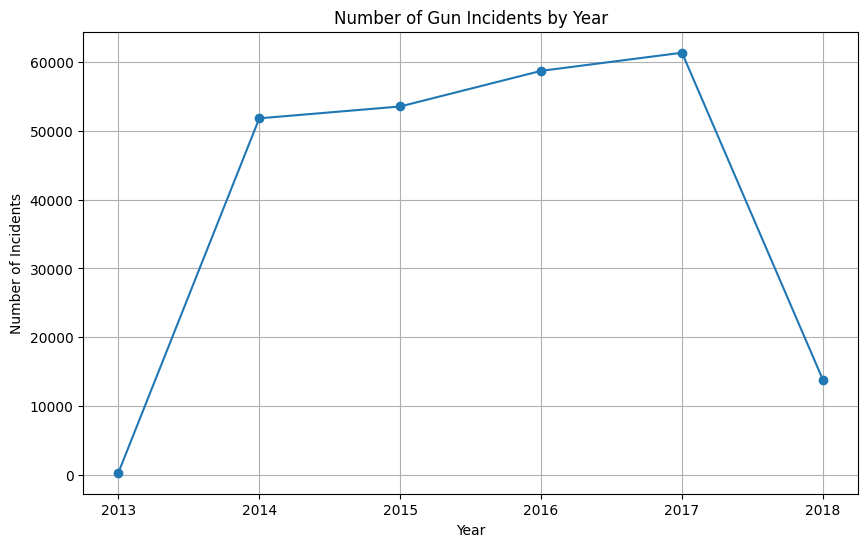

In [ ]:
import matplotlib.pyplot as plt

# Filter out rows with null values in the 'year' column
incidents_by_year = incidents_by_year.filter(incidents_by_year.year.isNotNull())

year_data = incidents_by_year.collect()

# Unpack the years and counts into separate lists
years = [row['year'] for row in year_data]
counts = [row['count'] for row in year_data]

# Create the line graph for year-wise data
plt.figure(figsize=(10, 6))
plt.plot(years, counts, marker='o', linestyle='-')
plt.title('Number of Gun Incidents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.xticks(years)  # Ensure all years are shown
plt.grid(True)
plt.show()


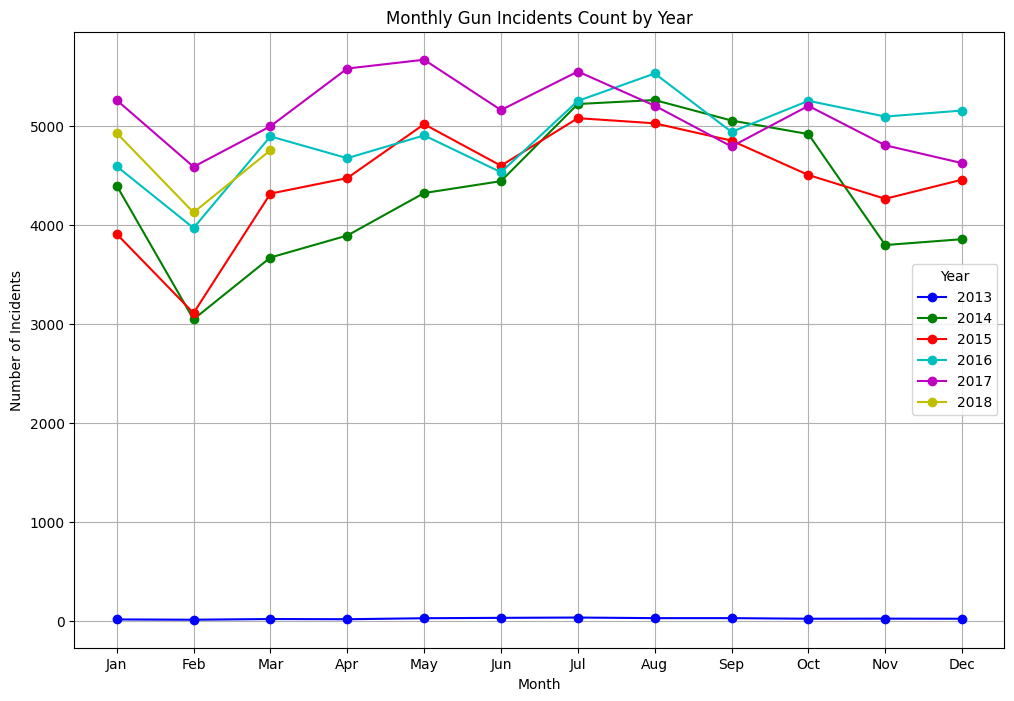

In [ ]:
import matplotlib.pyplot as plt

incidents_by_year_month = gun.groupBy("year", "month") \
                             .agg(count("date").alias("count")) \
                             .orderBy("year", "month")

# Collect the aggregated data
incidents_year_month_data = incidents_by_year_month.collect()

# Sort the data by year and month for consistency in plotting
incidents_year_month_data.sort(key=lambda x: (x['year'], x['month']))

years = sorted(set([row['year'] for row in incidents_year_month_data]))

colors = ['b', 'g', 'r', 'c', 'm', 'y']
color_map = {year: colors[i % len(colors)] for i, year in enumerate(years)}

# Prepare the plot
plt.figure(figsize=(12, 8))

for year in years:
    # Extract month and count data for the current year
    month_counts = [(row['month'], row['count']) for row in incidents_year_month_data if row['year'] == year]
    month_counts.sort(key=lambda x: x[0])
    months, counts = zip(*month_counts)  # Unzip the month_counts tuples into two lists

    plt.plot(months, counts, marker='o', linestyle='-', color=color_map[year], label=str(year))

# Configure the plot
plt.title('Monthly Gun Incidents Count by Year')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Year")
plt.grid(True)


plt.show()


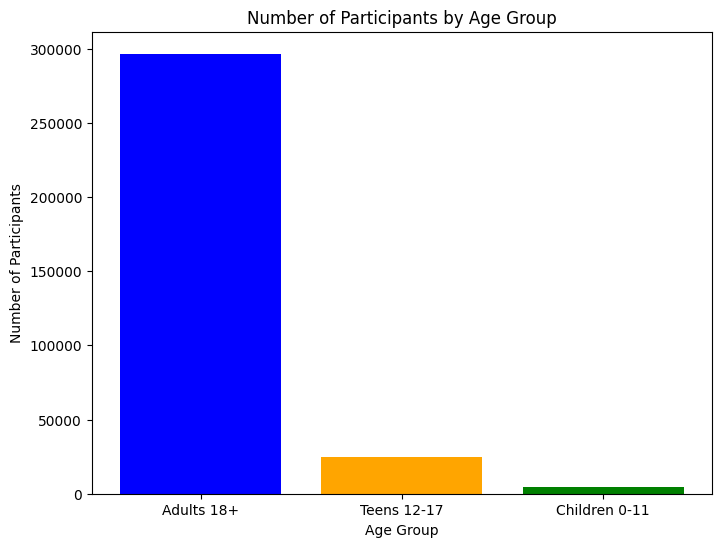

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

sums_df = gun.agg(
    F.sum("adult_count").alias("total_adult_count"),
    F.sum("teen_count").alias("total_teen_count"),
    F.sum("child_count").alias("total_child_count")
)

sums_dict = sums_df.collect()[0].asDict()

# Prepare data for plotting
age_groups = ['Adults 18+', 'Teens 12-17', 'Children 0-11']
counts = [sums_dict['total_adult_count'], sums_dict['total_teen_count'], sums_dict['total_child_count']]

plt.figure(figsize=(8, 6))
plt.bar(age_groups, counts, color=['blue', 'orange', 'green'])

plt.xlabel('Age Group')
plt.ylabel('Number of Participants')
plt.title('Number of Participants by Age Group')

plt.show()


In [ ]:
from pyspark.ml.feature import Tokenizer, NGram
from pyspark.sql.functions import explode, lower, col

# Tokenize the incident_characteristics column
tokenizer = Tokenizer(inputCol="incident_characteristics", outputCol="tokens")
df_tokens = tokenizer.transform(gun)

# Generate 2-gram, 3-gram, and 4-gram sequences from the tokens column
ngram_2 = NGram(n=2, inputCol="tokens", outputCol="2grams")
ngram_3 = NGram(n=3, inputCol="tokens", outputCol="3grams")
ngram_4 = NGram(n=4, inputCol="tokens", outputCol="4grams")

# Apply the n-gram transformations
df_2grams = ngram_2.transform(df_tokens)
df_3grams = ngram_3.transform(df_tokens)
df_4grams = ngram_4.transform(df_tokens)

# Extract n-grams from the transformed data
df_2grams_exploded = df_2grams.select(explode("2grams").alias("ngram"))
df_3grams_exploded = df_3grams.select(explode("3grams").alias("ngram"))
df_4grams_exploded = df_4grams.select(explode("4grams").alias("ngram"))

print("2-grams:")
df_2grams_exploded.show(truncate=False)

print("3-grams:")
df_3grams_exploded.show(truncate=False)

print("4-grams:")
df_4grams_exploded.show(truncate=False)


2-grams:
+--------------------------------+
|ngram                           |
+--------------------------------+
|shot -                          |
|- wounded/injured||mass         |
|wounded/injured||mass shooting  |
|shooting (4+                    |
|(4+ victims                     |
|victims injured                 |
|injured or                      |
|or killed                       |
|killed excluding                |
|excluding the                   |
|the subject/suspect/perpetrator,|
|subject/suspect/perpetrator, one|
|one location)||possession       |
|location)||possession (gun(s)   |
|(gun(s) found                   |
|found during                    |
|during commission               |
|commission of                   |
|of other                        |
|other crimes)||possession       |
+--------------------------------+
only showing top 20 rows

3-grams:
+------------------------------------------------------+
|ngram                                                 |
+-

In [ ]:
from pyspark.ml.feature import StopWordsRemover

# Remove stopwords
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
df_filtered = stopwords_remover.transform(df_tokens)

# Flatten tokens for frequency analysis
df_flat_tokens = df_filtered.select(explode("filtered_tokens").alias("token"))

# Count the frequency of each token
token_frequency = df_flat_tokens.groupBy("token").count().orderBy("count", ascending=False)

meaningful_threshold = 10  # Example threshold
meaningful_words = token_frequency.filter(token_frequency["count"] > meaningful_threshold)

meaningful_words.show()


+-----------------+------+
|            token| count|
+-----------------+------+
|                -|242711|
|             shot|141035|
|         (murder,| 53409|
|      accidental,| 53409|
|             dead| 53409|
|  wounded/injured| 47541|
|         involved| 44737|
|            shots| 43110|
|            found| 41646|
|     non-shooting| 41541|
|            fired| 36860|
|       commission| 30863|
|          (gun(s)| 30863|
|         shooting| 27328|
|         suicide)| 26310|
|         evidence| 21765|
|          robbery| 20320|
|incident||officer| 20156|
|              gun| 20143|
|     injury/death| 20059|
+-----------------+------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import explode, col

df_flat_tokens = df_filtered.select(explode("filtered_tokens").alias("token"))

df_filtered_tokens = df_flat_tokens.filter(df_flat_tokens.token != "-")

token_frequency = df_filtered_tokens.groupBy("token").count().orderBy(col("count").desc())

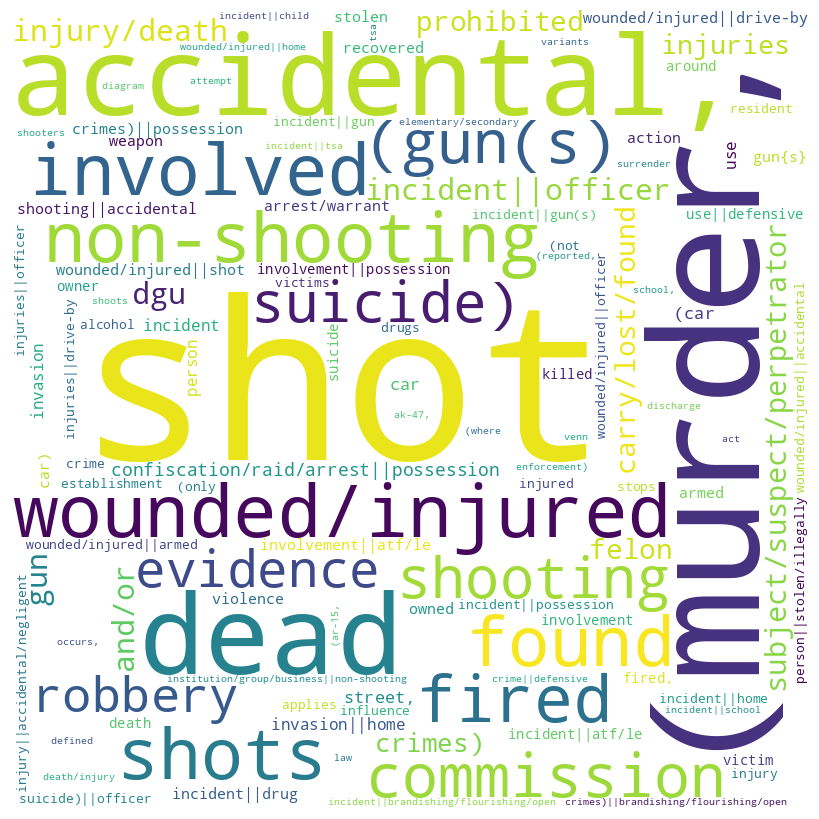

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

top_n_words_pd = token_frequency.toPandas()

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate_from_frequencies(dict(zip(top_n_words_pd['token'], top_n_words_pd['count'])))

# Display the generated image:
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


<Figure size 1200x800 with 0 Axes>

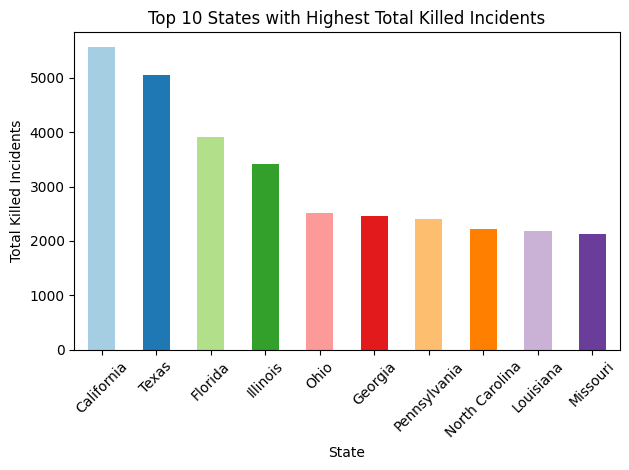

In [ ]:

# Count the number of killed for each state
state_killed_counts = gun.groupBy("state").sum("n_killed").withColumnRenamed("sum(n_killed)", "total_killed")

# Convert the Spark DataFrame to a Pandas DataFrame
state_killed_counts_pd = state_killed_counts.toPandas()

# Assuming you have pandas and matplotlib installed, create a bar chart
import matplotlib.pyplot as plt

# Sort the DataFrame and get the top 10 states with the highest 'total_killed'
top_10_states = state_killed_counts_pd.sort_values('total_killed', ascending=False).head(10)

# Assuming you have pandas and matplotlib installed, create a bar chart
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Plotting the bar chart with different colors for each bar
top_10_states.plot.bar(x='state', y='total_killed', legend=None, color=plt.cm.Paired(range(len(top_10_states))))

# Setting the title and labels
plt.title('Top 10 States with Highest Total Killed Incidents')
plt.xlabel('State')
plt.ylabel('Total Killed Incidents')

# Displaying the bar chart
plt.xticks(rotation=45)  # Rotate the x labels to show them more clearly
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


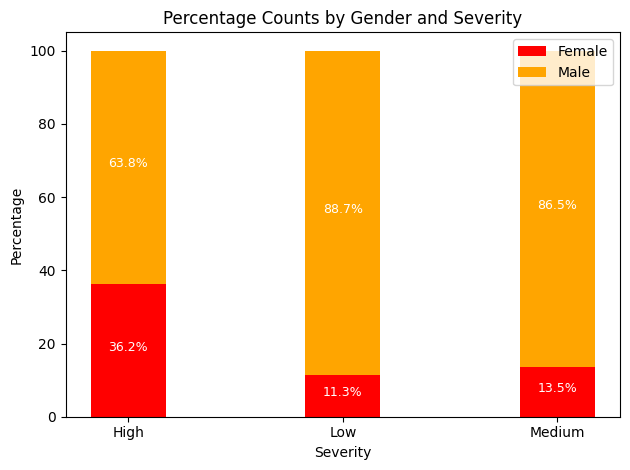

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `severity_gender_counts` is your DataFrame with the shown structure
severity = ['High', 'Low', 'Medium']
female_counts = np.array([1189, 26439, 14022])
male_counts = np.array([2099, 207054, 90041])

# Calculate total counts for each severity level
total_counts = female_counts + male_counts

# Calculate percentages
female_percentages = (female_counts / total_counts) * 100
male_percentages = (male_counts / total_counts) * 100

# Positions of the bars on the x-axis
ind = np.arange(len(severity))

# Size of the bars: can also be len(x) sequence
width = 0.35

fig, ax = plt.subplots()

# Plotting
p1 = ax.bar(ind, female_percentages, width, label='Female', color='red')
p2 = ax.bar(ind, male_percentages, width, bottom=female_percentages, label='Male', color='orange')

ax.set_title('Percentage Counts by Gender and Severity')
ax.set_xticks(ind)
ax.set_xticklabels(severity)
ax.legend()

# Labels for y-axis and x-axis
ax.set_ylabel('Percentage')
ax.set_xlabel('Severity')

# Adding percentage values above bars
for i, (fp, mp) in enumerate(zip(female_percentages, male_percentages)):
    ax.text(i, fp / 2, f"{fp:.1f}%", ha='center', color='white', fontsize=9)
    ax.text(i, fp + mp / 2, f"{mp:.1f}%", ha='center', color='white', fontsize=9)

plt.tight_layout()
plt.show()


# **Unsupervised learning**

##**Clustering cities based on the risk**##

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:

df = gun.limit(gun.count())
assembler = VectorAssembler(inputCols=['n_killed','n_injured','year','quarter','month','home invasion','drug involvement','defensive use','kidnapping','domestic violence ' ,'gun range','school shooting','workplace shooting','hate crime','house party','political violence','spree shooting','attempted murder','sex crime','road rage','accidental','mass shooting'], outputCol="features")
df_kmeans = assembler.transform(df)


In [ ]:
# Set the number of clusters (k)
from pyspark.ml.clustering import KMeans
k = 3  # Example value; adjust based on your data and domain knowledge

# Train the K-means model
kmeans = KMeans().setK(k).setSeed(100).setFeaturesCol("features")

#model=clusterpipeline.transform(test)
model = kmeans.fit(df_kmeans)

# Make predictions
predictions = model.transform(df_kmeans)


In [ ]:
# Display cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# Optionally, examine the counts of instances in each cluster or any other statistics.


Cluster Centers: 
[2.57402589e-01 4.62135291e-01 2.01613560e+03 1.00000000e+00
 1.99301555e+00 4.55460571e-02 8.37359846e-02 3.07253918e-02
 1.05153937e-02 0.00000000e+00 1.65706498e-03 1.79644428e-03
 6.96896488e-04 2.94245184e-04 2.94245184e-03 4.64597658e-05
 1.48671251e-03 2.43139441e-03 2.53980053e-03 9.38487270e-03
 2.56008796e-01 5.31189989e-03]
[2.53160367e-01 5.00217243e-01 2.01553867e+03 3.57900399e+00
 9.92189601e+00 4.56210043e-02 7.01073801e-02 3.18726336e-02
 1.17207705e-02 0.00000000e+00 1.82070221e-03 1.94484100e-03
 7.65522521e-04 4.86210250e-04 3.65174932e-03 7.24142925e-05
 1.89311650e-03 1.88277161e-03 2.90691660e-03 8.86557838e-03
 2.53005193e-01 6.90004759e-03]
[2.47007229e-01 5.12589401e-01 2.01557576e+03 2.26933031e+00
 5.54027971e+00 4.19306722e-02 6.26601563e-02 2.96536162e-02
 1.10276776e-02 0.00000000e+00 1.92506279e-03 1.13463966e-03
 7.13930570e-04 4.58955367e-04 2.85572228e-03 3.82462805e-05
 1.51710246e-03 1.65733882e-03 2.66449088e-03 8.63091064e-03
 2.

In [ ]:
from pyspark.sql.functions import mean, count,sum

# Assuming 'predictions' contains your data with a 'prediction' column for clusters
cluster_summary = predictions.groupBy("prediction").agg(
    sum("n_killed").alias("sum_n_killed"),
    sum("n_injured").alias("sum_n_injured"),
    sum("mass shooting").alias("total_mass_shooting"),
    sum("school shooting").alias("total school shooting"),
    sum("road rage").alias("total road rage"),
    count("*").alias("total_incidents")
).orderBy("prediction")


In [ ]:
cluster_summary_pd = cluster_summary.toPandas()
print(cluster_summary_pd)


   prediction  sum_n_killed  sum_n_injured  total_mass_shooting  \
0           0         16621          29841                  343   
1           1         24472          48354                  667   
2           2         19375          40207                  627   

   total school shooting  total road rage  total_incidents  
0                    116              606            64572  
1                    188              857            96666  
2                     89              677            78439  


Based on the cluster summary,we can classify cluster 1 to be **high risk** ,cluster 2 to be **medium risk** and cluster 3 to be **low risk**.

--------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Example UDF to label clusters
def label_cluster(cluster):
    if cluster == 1:
      return "High Risk"
    elif cluster == 2:
      return "Medium Risk"
    else:
        return "Low Risk"

# Register UDF
label_cluster_udf = udf(label_cluster, StringType())

# Add risk label column based on cluster prediction
predictions = predictions.withColumn("risk_label", label_cluster_udf("prediction"))

predictions.select("city_or_county", "prediction", "risk_label").show()


+--------------+----------+----------+
|city_or_county|prediction|risk_label|
+--------------+----------+----------+
|    Mckeesport|         0|  Low Risk|
|     Hawthorne|         0|  Low Risk|
|        Lorain|         0|  Low Risk|
|        Aurora|         0|  Low Risk|
|    Greensboro|         0|  Low Risk|
|         Tulsa|         0|  Low Risk|
|   Albuquerque|         0|  Low Risk|
|   New Orleans|         0|  Low Risk|
|     Brentwood|         0|  Low Risk|
|     Baltimore|         0|  Low Risk|
|   Chattanooga|         0|  Low Risk|
|   Saint Louis|         0|  Low Risk|
|     Charenton|         0|  Low Risk|
|    Washington|         0|  Low Risk|
|   Springfield|         0|  Low Risk|
|       Memphis|         0|  Low Risk|
| Yuba (county)|         0|  Low Risk|
|       Chicago|         0|  Low Risk|
|   New Orleans|         0|  Low Risk|
|       Vallejo|         0|  Low Risk|
+--------------+----------+----------+
only showing top 20 rows



In [ ]:
city_risk_summary = predictions.groupBy("city_or_county","risk_label").agg(
    F.count("*").alias("total_incidents"),
    F.sum(F.when(F.col("risk_label") == "High Risk", 1).otherwise(0)).alias("high_risk_incidents"),
    F.sum(F.when(F.col("risk_label") == "Medium Risk", 1).otherwise(0)).alias("medium_risk_incidents"),
    F.sum(F.when(F.col("risk_label") == "Low Risk", 1).otherwise(0)).alias("low_risk_incidents"),
    F.sum("n_killed").alias("Total killed"),
    F.sum("n_injured").alias("Toal injured"),
    F.avg(
        F.when(
            (F.col("latitude") != 0) &
            (F.col("latitude") != -1) &
            (~F.isnan("latitude")),
            F.col("latitude")
        )
    ).alias("avg_latitude"),
    F.avg(
        F.when(
            (F.col("longitude") != 0) &
            (F.col("longitude") != -1) &
            (~F.isnan("longitude")),
            F.col("longitude")
        )
    ).alias("avg_longitude")
)

In [ ]:
city_risk_summary.show()

+--------------+-----------+---------------+-------------------+---------------------+------------------+------------+------------+------------------+-------------------+
|city_or_county| risk_label|total_incidents|high_risk_incidents|medium_risk_incidents|low_risk_incidents|Total killed|Toal injured|      avg_latitude|      avg_longitude|
+--------------+-----------+---------------+-------------------+---------------------+------------------+------------+------------+------------------+-------------------+
|       Memphis|Medium Risk|            833|                  0|                  833|                 0|         188|         585| 35.11572798552468| -89.95091531966234|
|       Oakland|Medium Risk|            311|                  0|                  311|                 0|          91|         254|37.856483986928104|-121.05418464052298|
|         Vista|   Low Risk|              8|                  0|                    0|                 8|           7|           3|         33.18

In [ ]:
from pyspark.sql.functions import col, when

# This adds a column that inversely ranks low-risk areas by their safety,
# while directly ranking high-risk areas by their danger.
city_risk_summary = city_risk_summary.withColumn(
    "ordering_metric",
    when(col("risk_label") == "Low Risk", -col("total killed") - col("toal injured"))
    .otherwise(col("total_incidents"))
)


In [ ]:
from pyspark.sql.window import Window
windowSpec = Window.partitionBy("risk_label").orderBy(F.col("ordering_metric").desc())

ranked = city_risk_summary.withColumn("rank", F.rank().over(windowSpec))

top_places = ranked.filter(F.col("rank") <= 50)

In [ ]:

from pyspark.sql.functions import col, row_number

# Assuming 'city_risk_summary' is your DataFrame
# Define a window spec partitioned by 'risk_label' and ordered by your custom ordering metric
windowSpec = Window.partitionBy("risk_label").orderBy(col("ordering_metric").desc())

# Use row_number() to assign a unique sequential number to each row within each partition
ranked = city_risk_summary.withColumn("row_number", row_number().over(windowSpec))

# Filter to select only the first 5 rows within each partition
top_5_places = ranked.filter(col("row_number") <= 5)

low_high_risk_places = top_5_places.filter(
    (col("risk_label") == "Low Risk") | (col("risk_label") == "High Risk")
)

# Show the results
low_high_risk_places.show()


+------------------+----------+---------------+-------------------+---------------------+------------------+------------+------------+-----------------+------------------+---------------+----------+
|    city_or_county|risk_label|total_incidents|high_risk_incidents|medium_risk_incidents|low_risk_incidents|Total killed|Toal injured|     avg_latitude|     avg_longitude|ordering_metric|row_number|
+------------------+----------+---------------+-------------------+---------------------+------------------+------------+------------+-----------------+------------------+---------------+----------+
|           Chicago| High Risk|           4557|               4557|                    0|                 0|         902|        4367|41.82616078706971|-87.67501569454153|           4557|         1|
|         Baltimore| High Risk|           1634|               1634|                    0|                 0|         411|        1027|39.30460955974846|-76.62560446540871|           1634|         2|
|    

In [ ]:
city_aggregates_pd = city_risk_summary.toPandas()
city_aggregates_pd['avg_latitude'].fillna(value=0, inplace=True)
city_aggregates_pd['avg_longitude'].fillna(value=0, inplace=True)

In [ ]:
import plotly.express as px
import pandas as pd

top_places_pd = top_places.toPandas()
top_places_pd['avg_latitude'] = pd.to_numeric(top_places_pd['avg_latitude'], errors='coerce')
top_places_pd['avg_longitude'] = pd.to_numeric(top_places_pd['avg_longitude'], errors='coerce')

top_places_pd = top_places_pd.dropna(subset=['avg_latitude', 'avg_longitude'])

# Plotting
fig = px.scatter_mapbox(top_places_pd,
                        lat="avg_latitude",
                        lon="avg_longitude",
                        color="risk_label",  # Column to determine the color of points
                        hover_name="city_or_county",  # Column to show in hover
                        hover_data={"avg_latitude": False,  # Hide latitude info in hover
                                    "avg_longitude": False,  # Hide longitude info in hover
                                    "risk_label": True},  # Show risk label info in hover
                        color_discrete_map={"High Risk": "red", "Medium Risk": "orange", "Low Risk": "green"},
                        zoom=3,
                        height=600,
                        title="Top Cities by Risk Label")

# Improve mapbox style
fig.update_layout(mapbox_style="open-street-map")

# Show the figure
fig.show()


In [ ]:
from folium.plugins import HeatMap
import folium
risk_intensity = {
    'High Risk': 3,
    'Medium Risk': 2,
    'Low Risk': 1
}

top_places_pd['risk_intensity'] = top_places_pd['risk_label'].map(risk_intensity)

heat_data = [[row['avg_latitude'], row['avg_longitude'], row['risk_intensity']] for index, row in top_places_pd.iterrows() if not pd.isna(row['avg_latitude']) and not pd.isna(row['avg_longitude'])]

m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Add HeatMap layer to the map
HeatMap(heat_data, radius=15, gradient={0.2: 'green', 0.5: 'orange', 0.8: 'red'}).add_to(m)

m


In [ ]:
gun.show()

+-----------+----------+--------------------+--------------+--------+---------+----------------------+--------------------+--------------------+------------------------+--------+---------+---------------+--------------------+---------------------+--------------------+------------------------+--------------------+--------------------+--------------------+---------------------+----+-------+-----+---+-------+------------------+----------------------+-------------------+-----------+----------+-----------+-------------------+-------------------+-------------------+--------------+--------------+---------------------+-------------+----------------+-------------+----------+------------------+---------+---------------+------------------+----------+-----------+------------------+--------------+----------------+---------+---------+----------+-------------+--------+----------+------------+
|incident_id|      date|               state|city_or_county|n_killed|n_injured|congressional_district|       

# **Classifying the severity of an incident**

In [ ]:
from pyspark.ml.feature import StringIndexer
str_obj=StringIndexer(inputCols=["state","city_or_county","state_house_district","severity"],outputCols=["newstate","newcity_or_county","newstate_house_district","newseverity"], handleInvalid="keep")

In [ ]:
#Using one hot encoding for categorical variables
from pyspark.ml.feature import OneHotEncoder
onehot_obj=OneHotEncoder(inputCols=["newstate","newcity_or_county","newstate_house_district"],outputCols=["finalstate","finalcity_or_county","finalstate_house_district"])

In [ ]:
from  pyspark.ml.feature import VectorAssembler
vec_obj=VectorAssembler(inputCols=["finalstate","finalcity_or_county","latitude","longitude","min_participant_age","max_participant_age","avg_participant_age","Arrested_count","home invasion","drug involvement","defensive use","kidnapping","domestic violence ","gun range","workplace shooting","hate crime","house party","political violence","spree shooting","attempted murder","sex crime","mass shooting","Female_count","Male_count"], outputCol="all_features")

In [ ]:
from pyspark.ml.feature import StandardScaler
ss = StandardScaler(inputCol="all_features", outputCol="all_features_scaled")

In [ ]:
df = gun.dropna().limit(50000)
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline



In [ ]:
forest=RandomForestClassifier(featuresCol='all_features_scaled', labelCol="newseverity")


In [ ]:
forestpipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,ss,forest])


In [ ]:
training, test=df.randomSplit([0.75,0.25], seed=1000)

In [ ]:
forestmodel=forestpipeline.fit(training)

In [ ]:
forestresults=forestmodel.transform(test)
forestresults.show(2, truncate=False)

+-----------+----------+--------+--------------+--------+---------+----------------------+----------+----------+-----------------------------------------------------------------------------------+--------+---------+---------------+---------------+---------------------+------------------+------------------------+------------------+------------------+--------------------+---------------------+----+-------+-----+---+-------+------------------+----------------------+-------------------+-----------+----------+-----------+-------------------+-------------------+-------------------+--------------+--------------+-------------------------------------------------------------------------------------+-------------+----------------+-------------+----------+------------------+---------+---------------+------------------+----------+-----------+------------------+--------------+----------------+---------+---------+----------+-------------+--------+----------+------------+--------+-----------------+---

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="newseverity", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(forestresults)
print("Test set accuracy = " + str(accuracy))


Test set accuracy = 0.7789143041237113


So we can see that the severity of the incident could be predicted using the features of the incident.